In [1]:
#Degrees of freedom: $\alpha,\theta$ 
#Intermediate angles:$\beta,\gamma$
#Lengths:$L_1,L_2,L_3,L_4$
#Linear Stiffnesses: $C_1,C_2,C_3,C_4$
#Rotational Stiffnesses: $K_f1,K_f2,K_f3,K_f4$
#intermediate displacements: $d_1,d_2,d_3,d_4$
#weighing stiffnesses $K_1,K_2,K_3$

In [3]:
import sympy as sm
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from systemprbm import UnitCell, System
%matplotlib ipympl

#Define degrees of freedom, and initial values




In [57]:
# Define mechanism parameters
E = 2.2e9 #Young's modulus
t = 0.4e-3 #thickness
b = 5e-3    #width
Lf1 = 6e-3 #length of the flexure on end effector, and bifurcation
Lf2 = 4e-3 #length of the flexure on signal routing and bistable beams
Lr1 = 35e-3 #length of the rigid link on end effector
Lr2 = 24e-3 #length of the rigid link on bistable beams
Lr3 = 35e-3 #length of the rigid link on signal routing
Lr4 = 80e-3 #length of the rigid link on bifurcation
Ls1 = 6e-3 #length of the support on bistable beams
ts1 = 2e-3 #thickness of the support on bistable beams
Lsignal = 6e-3 #length of the signal routing spring leg

alpha0 = 24*np.pi/180 #initial angle of the end effector
beta0 = 8*np.pi/180 #initial angle of the bistable beams
gamma0 = 30*np.pi/180 #initial angle of the signal routing
theta0 = 2.5*np.pi/180 #initial angle of the bifurcation

kf1 = E*b*t**3/12/Lf1
kf2 = E*b*t**3/12/Lf2
kf3 = E*b*t**3/12/Lf2
kf4 = E*b*t**3/12/Lf1

C1 = E*b*ts1**3/Ls1**3 #bistable support stiffness
C2 = 2*E*b*t**3/Lr2**3 #signal routing guiding stiffness
C3 = 0.5*E*b*t**3/Lsignal**3/6 #signal routing stiffness
C4 = 5000 #bifurcation support stiffness

#todo fix these values

K1 = 0
K2 = 0
K3 = 0

tog_offset = 2e-3

params = {
    'L1': Lr1+Lf1,'L2': Lr2+Lf2,'L3': Lr3+Lf2,'L4': Lr4+Lf1,
    'C1': C1,'C2': C2,'C3': C3,'C4': C4,
    'Kf1': kf1,'Kf2': kf2,'Kf3': kf3,'Kf4': kf4,
    'alpha0': alpha0,'beta0': beta0,'gamma0': gamma0,'theta0': theta0,
    'K1': K1,'K2': K2,'K3': K3,
    'tog_offset': tog_offset,
    } 




In [58]:
#creeat a system with one unit cell and get the force residuals as alpha is swept from 22 degrees to -22 degrees using the bounds, solving for the equilivrium state at each step, and plotting the force residuals

params['K1'] = 10   
params['K2'] = 10   
params['K3'] = 10

# define initial configuration
config = [0]


# Create system
system = System(config,params)

#between alpha0 and -alpha0, sweep alpha and solve for the equilibrium state

system.u = -2e-2


In [59]:
system.get_quantity('K1_tog')[0]

0.0

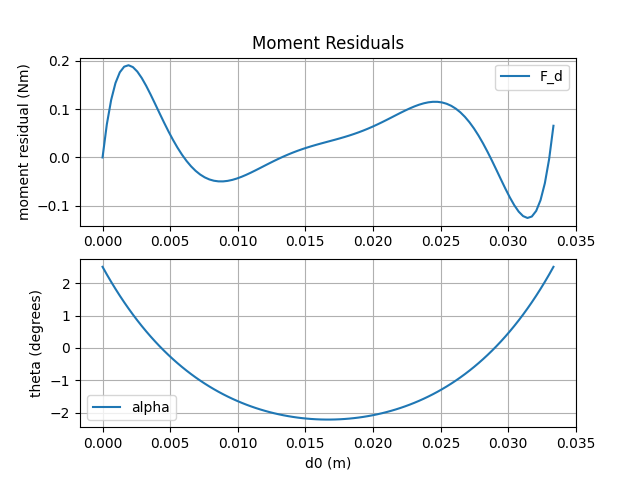

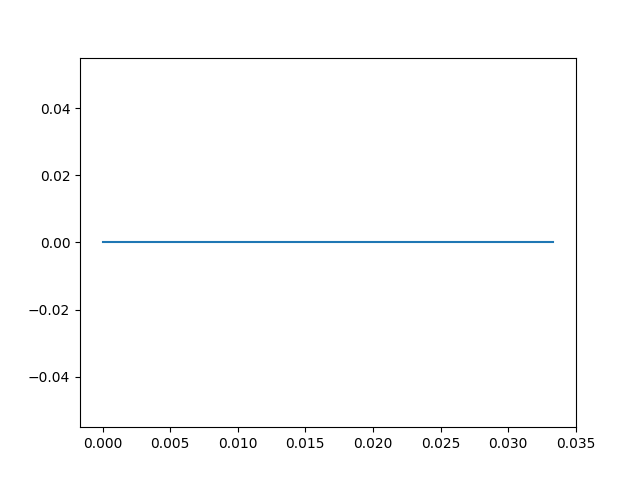

In [60]:
alpha_range = np.linspace(alpha0,-alpha0,100)
force_residuals = np.zeros((len(alpha_range),2))
state_vectors = np.zeros((len(alpha_range),2))

K1_toggles = np.zeros((len(alpha_range),1))

bub = np.copy(system.bounds.ub)
blb = np.copy(system.bounds.lb)

for i,alpha in enumerate(alpha_range):
    #update the bounds
    

    blb[0] = alpha
    bub[0] = alpha

    system.bounds.ub = bub
    system.bounds.lb = blb
    #solve for the equilivrium state
    system.solve_equilibrium()

    #get the force residuals
    force_residuals[i] = system.compute_residuals()
    state_vectors[i] = system.state_vector
    K1_toggles[i] = system.get_quantity('K1_tog')[0]


from scipy.signal import find_peaks

#find the peaks of the force residuals
peaks, _ = find_peaks(-force_residuals[:,0],height=0.1)
zero_crossings = np.where(np.diff(np.sign(force_residuals[:,0])))[0]

plt.figure()
#create two subplots, one for the force residuals and one for the state vectors
#plot the negative of the force residuals against d0 as a function of alpha 

d0 = params['L1']*(np.sin(params['alpha0'])-np.sin(alpha_range))
ax1 = plt.subplot(211)
ax1.plot(d0,-force_residuals[:,0])


ax1.set_ylabel('moment residual (Nm)')
ax1.legend(['F_d','F_b'])
ax1.set_title('Moment Residuals')
ax1.grid()

ax2 = plt.subplot(212)
#plot theta as a function of d0 
ax2.plot(d0,state_vectors[:,1]*180/np.pi)
ax2.set_xlabel('d0 (m)')
ax2.set_ylabel('theta (degrees)')
ax2.legend(['alpha','theta'])
ax2.grid()

plt.figure()
plt.plot(d0,K1_toggles)



slopes ratio: 2.21
slopes: -6.23, -13.73


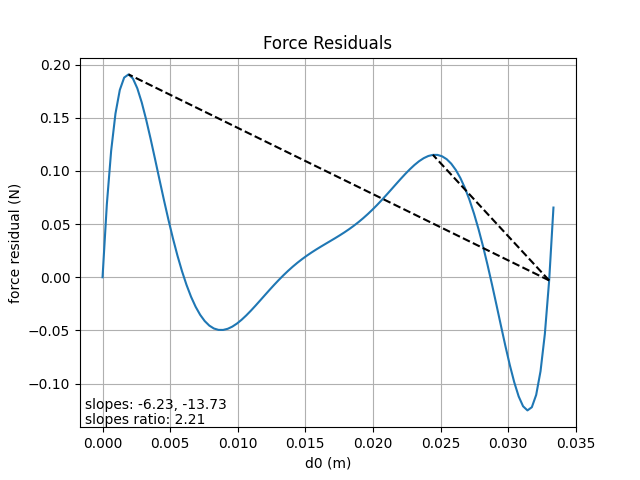

In [61]:
#plot the force residuals as a function of d0
plt.figure()
plt.plot(d0,-force_residuals[:,0])
#draw lines from the last zero crossing to the peaks of the force residuals
slopes = np.zeros(len(peaks))
for peak in peaks:
    plt.plot([d0[zero_crossings[-1]],d0[peak]],[-force_residuals[zero_crossings[-1],0],-force_residuals[peak,0]],'k--')
    #find slope of lines
    slope = (-force_residuals[peak,0]+force_residuals[zero_crossings[-1],0])/(d0[peak]-d0[zero_crossings[-1]])
    slopes[peaks==peak] = slope

#print the ratio of the slopes on the figure
plt.text(0.01,0.01,'slopes ratio: {:.2f}'.format(slopes[1]/slopes[0]),transform=plt.gca().transAxes)
#print the slopes on the figure at the midpoint of the lines
plt.text(0.01,0.05,'slopes: {:.2f}, {:.2f}'.format(slopes[0],slopes[1]),transform=plt.gca().transAxes)

print('slopes ratio: {:.2f}'.format(slopes[1]/slopes[0]))
print('slopes: {:.2f}, {:.2f}'.format(slopes[0],slopes[1]))



plt.xlabel('d0 (m)')
plt.ylabel('force residual (N)')
plt.title('Force Residuals')

plt.grid()



In [62]:
config = [0,0,1,0,0]

# Initialize system with initial configuration of alphas

params['K1'] = 0
params['K2'] = 0
params['K3'] = 150


# define initial configuration
config = [0]


# Create system
system = System(config,params)
#print the state in degrees



# fig, _ = system.plot_system()



u_range = np.linspace(0, 16e-3, 400)
results = system.simulate_actuation(u_range)

system.plot_system()

plt.figure()
plt.subplot(2, 1, 1)
for i in range(system.n):
    plt.plot(u_range, results[:, 2*i])

#axis labels
plt.xlabel('Actuation [m]')
plt.ylabel(' alpha angle [rad]')
plt.ylim([-0.5, 0.5])


plt.subplot(2, 1, 2)
for i in range(system.n):
    plt.plot(u_range, results[:, 2*i+1])

#axis labels
plt.xlabel('Actuation [m]')
plt.ylabel(' theta angle [rad]')
plt.legend(['theta0', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6'])
d6 = params['L4']*(np.sin(params['theta0'])-np.sin(results[:, 1]))

# plt.subplot(3, 1, 3)
# plt.plot(u_range, d6)






AttributeError: 'numpy.ndarray' object has no attribute 'append'

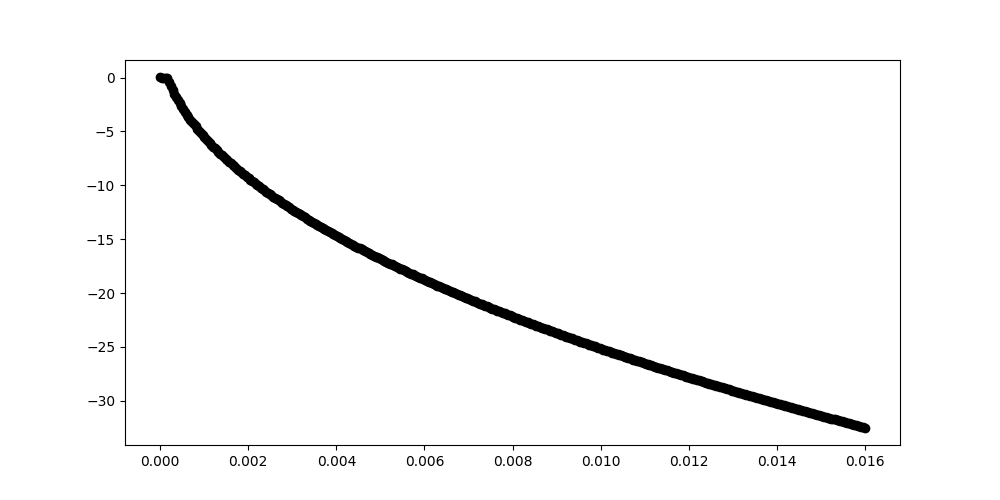

In [96]:
#plot d6 vs alpha
plt.figure(figsize=(10,5))
plt.plot(u_range, d6*1000, 'o', color='black')


In [92]:
import matplotlib.animation as animation
from IPython import display


#animate the system
system = System(unit_cells)
system.solve_equilibrium()
fig, _ = system.plot_system()

anim = animation.FuncAnimation(fig, system.update_plot,fargs=(results,), frames=100, interval=20, blit=True)

video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

Todo:
-set coupling stiffness to zero, sweep alpha, plot residuals [Done]
-set correct coupling stiffnesses 
- extract other values from prbm (i.e. intermediate angles)
-implement optimisation algorithm [Done?]
-implement constraints handling: spring or optimisation constraints?
-visualise system

